# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import pandas as pd

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [2]:
tracks = pd.read_parquet('tracks.parquet')
catalog_names = pd.read_parquet('catalog_names.parquet')
interactions = pd.read_parquet('interactions.parquet')

In [3]:
print("tracks:")
print(tracks.info())
print("\ncatalog_names:")
print(catalog_names.info())
print("\ninteractions:")
print(interactions.info())

tracks:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB
None

catalog_names:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB
None

interactions:
<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  date

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [4]:
print(f"tracks.track_id: {tracks['track_id'].dtype}")
print(f"catalog_names.id: {catalog_names['id'].dtype}")
print(f"interactions.user_id: {interactions['user_id'].dtype}")
print(f"interactions.track_id: {interactions['track_id'].dtype}")

tracks.track_id: int64
catalog_names.id: int64
interactions.user_id: int32
interactions.track_id: int32


In [5]:
#приведу к 1 типу
tracks['track_id'] = tracks['track_id'].astype('int32')
catalog_names['id'] = catalog_names['id'].astype('int32')

In [6]:
print("\nПропуски в tracks:")
print(tracks.isnull().sum())

print("\nПропуски в catalog_names:")
print(catalog_names.isnull().sum())

print("\nПропуски в interactions:")
print(interactions.isnull().sum())


Пропуски в tracks:
track_id    0
albums      0
artists     0
genres      0
dtype: int64

Пропуски в catalog_names:
id      0
type    0
name    0
dtype: int64

Пропуски в interactions:
user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64


In [7]:
from ast import literal_eval
import numpy as np

def safe_literal_eval(val):
    """Безопасное преобразование строки в список"""
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return []
    if isinstance(val, list):
        return val
    try:
        result = literal_eval(str(val))
        return result if isinstance(result, list) else []
    except:
        return []

# Проверим, что на самом деле в колонках
print("\nПример значений до преобразования:")
print(f"Type of albums[0]: {type(tracks['albums'].iloc[0])}")
print(f"albums[0]: {tracks['albums'].iloc[0]}")

# Если данные уже в формате списков (из parquet), то преобразование не требуется
if isinstance(tracks['albums'].iloc[0], list):
    print("\nДанные уже в формате списков, преобразование не требуется")
else:
    # Если это строки, то преобразуем
    tracks['albums'] = tracks['albums'].apply(safe_literal_eval)
    tracks['artists'] = tracks['artists'].apply(safe_literal_eval)
    tracks['genres'] = tracks['genres'].apply(safe_literal_eval)
    print("\nПреобразование завершено")


Пример значений до преобразования:
Type of albums[0]: <class 'numpy.ndarray'>
albums[0]: [      3 2490753]

Преобразование завершено


In [8]:

# Проверяем треки с пустыми списками
tracks_empty_albums = tracks[tracks['albums'].apply(len) == 0]
tracks_empty_artists = tracks[tracks['artists'].apply(len) == 0]
tracks_empty_genres = tracks[tracks['genres'].apply(len) == 0]

print(f"\nКоличество треков с неизвестными альбомами: {len(tracks_empty_albums)} ({len(tracks_empty_albums)/len(tracks)*100:.2f}%)")
print(f"Количество треков с неизвестными исполнителями: {len(tracks_empty_artists)} ({len(tracks_empty_artists)/len(tracks)*100:.2f}%)")
print(f"Количество треков с неизвестными жанрами: {len(tracks_empty_genres)} ({len(tracks_empty_genres)/len(tracks)*100:.2f}%)")



Количество треков с неизвестными альбомами: 319026 (31.90%)
Количество треков с неизвестными исполнителями: 216339 (21.63%)
Количество треков с неизвестными жанрами: 622255 (62.23%)


In [9]:
UNKNOWN_ARTIST_ID = -1
UNKNOWN_ALBUM_ID = -1
UNKNOWN_GENRE_ID = -1

# Добавляем записи для неизвестных значений в catalog_names
unknown_entries = [
    {'id': UNKNOWN_ARTIST_ID, 'type': 'artist', 'name': 'Unknown Artist'},
    {'id': UNKNOWN_ALBUM_ID, 'type': 'album', 'name': 'Unknown Album'},
    {'id': UNKNOWN_GENRE_ID, 'type': 'genre', 'name': 'Unknown Genre'}
]

# Проверяем, есть ли уже такие записи
for entry in unknown_entries:
    if not ((catalog_names['id'] == entry['id']) & (catalog_names['type'] == entry['type'])).any():
        catalog_names = pd.concat([catalog_names, pd.DataFrame([entry])], ignore_index=True)
        print(f"Добавлена запись: {entry['name']} (ID: {entry['id']})")

# Заполняем пустые списки в tracks
tracks['albums'] = tracks['albums'].apply(lambda x: [UNKNOWN_ALBUM_ID] if len(x) == 0 else x)
tracks['artists'] = tracks['artists'].apply(lambda x: [UNKNOWN_ARTIST_ID] if len(x) == 0 else x)
tracks['genres'] = tracks['genres'].apply(lambda x: [UNKNOWN_GENRE_ID] if len(x) == 0 else x)

print("\nВсе пустые списки заполнены значениями 'Unknown'")

Добавлена запись: Unknown Artist (ID: -1)
Добавлена запись: Unknown Album (ID: -1)
Добавлена запись: Unknown Genre (ID: -1)

Все пустые списки заполнены значениями 'Unknown'


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

In [10]:
tracks_empty_albums = tracks[tracks['albums'].apply(len) == 0]
tracks_empty_artists = tracks[tracks['artists'].apply(len) == 0]
tracks_empty_genres = tracks[tracks['genres'].apply(len) == 0]

print(f"\nКоличество треков с пустыми альбомами: {len(tracks_empty_albums)}")
print(f"Количество треков с пустыми исполнителями: {len(tracks_empty_artists)}")
print(f"Количество треков с пустыми жанрами: {len(tracks_empty_genres)}")

print("\nИтоговые размеры датасетов:")
print(f"tracks: {tracks.shape}")
print(f"catalog_names: {catalog_names.shape}")
print(f"interactions: {interactions.shape}")


Количество треков с пустыми альбомами: 0
Количество треков с пустыми исполнителями: 0
Количество треков с пустыми жанрами: 0

Итоговые размеры датасетов:
tracks: (1000000, 4)
catalog_names: (1812474, 3)
interactions: (222629898, 4)


1. Проверил типы идентификаторов и оптимизировал их для экономии (int64 -> int32)
2. Проверил наличие пропусков во всех датасетах, проанализировал треки с неизвестными данными (пустые списки альбомов, исполнителей, жанров)
- Преобразовал строковые представления списков в реальные списки Python
- Добавил специальные записи "Unknown" в catalog_names
- Заполнил пустые списки ссылками на "Unknown" записи

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import boto3
from io import BytesIO


Общая статистика по прослушиваниям:
Всего пользователей: 1,373,221
Всего треков: 1,000,000
Всего прослушиваний: 222,629,898

Статистика прослушиваний на пользователя:
count    1.373221e+06
mean     1.621224e+02
std      3.512846e+02
min      1.000000e+00
25%      2.300000e+01
50%      5.500000e+01
75%      1.540000e+02
max      1.663700e+04
dtype: float64


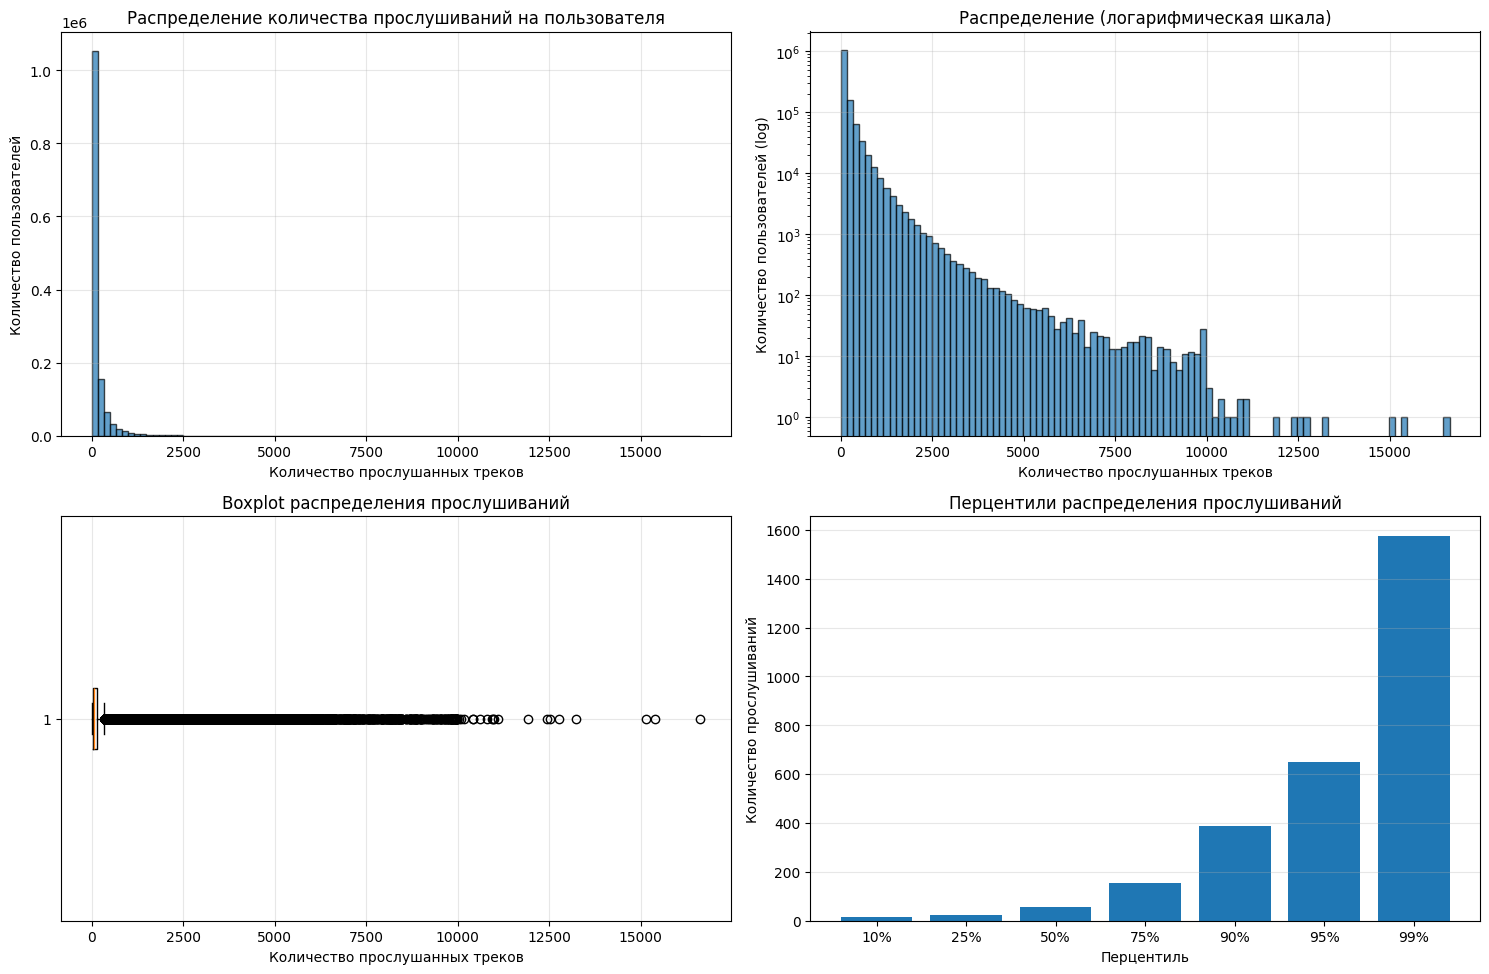

In [12]:
# Количество прослушиваний на пользователя
user_listens = interactions.groupby('user_id').size()

print(f"\nОбщая статистика по прослушиваниям:")
print(f"Всего пользователей: {interactions['user_id'].nunique():,}")
print(f"Всего треков: {interactions['track_id'].nunique():,}")
print(f"Всего прослушиваний: {len(interactions):,}")
print(f"\nСтатистика прослушиваний на пользователя:")
print(user_listens.describe())

# Визуализация распределения
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# График 1: Гистограмма (полное распределение)
axes[0, 0].hist(user_listens, bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Количество прослушанных треков')
axes[0, 0].set_ylabel('Количество пользователей')
axes[0, 0].set_title('Распределение количества прослушиваний на пользователя')
axes[0, 0].grid(True, alpha=0.3)

# График 2: Логарифмическая шкала
axes[0, 1].hist(user_listens, bins=100, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Количество прослушанных треков')
axes[0, 1].set_ylabel('Количество пользователей (log)')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Распределение (логарифмическая шкала)')
axes[0, 1].grid(True, alpha=0.3)

# График 3: Boxplot
axes[1, 0].boxplot(user_listens, vert=False)
axes[1, 0].set_xlabel('Количество прослушанных треков')
axes[1, 0].set_title('Boxplot распределения прослушиваний')
axes[1, 0].grid(True, alpha=0.3)

# График 4: Квантили
percentiles = [10, 25, 50, 75, 90, 95, 99]
percentile_values = [np.percentile(user_listens, p) for p in percentiles]
axes[1, 1].bar(range(len(percentiles)), percentile_values, tick_label=[f'{p}%' for p in percentiles])
axes[1, 1].set_xlabel('Перцентиль')
axes[1, 1].set_ylabel('Количество прослушиваний')
axes[1, 1].set_title('Перцентили распределения прослушиваний')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Наиболее популярные треки


Топ-20 самых популярных треков:
----------------------------------------------------------------------
 1. Smells Like Teen Spirit                  - Nirvana                   (111,062 прослушиваний)
 2. Believer                                 - Imagine Dragons           (106,921 прослушиваний)
 3. Numb                                     - Linkin Park               (101,924 прослушиваний)
 4. I Got Love                               - Unknown Artist            (99,490 прослушиваний)
 5. Юность                                   - Dabro                     (86,670 прослушиваний)
 6. Way Down We Go                           - KALEO                     (86,246 прослушиваний)
 7. Shape of You                             - Ed Sheeran                (85,886 прослушиваний)
 8. In The End                               - Unknown Artist            (85,244 прослушиваний)
 9. Shape Of My Heart                        - Sting                     (85,042 прослушиваний)
10. Life                     

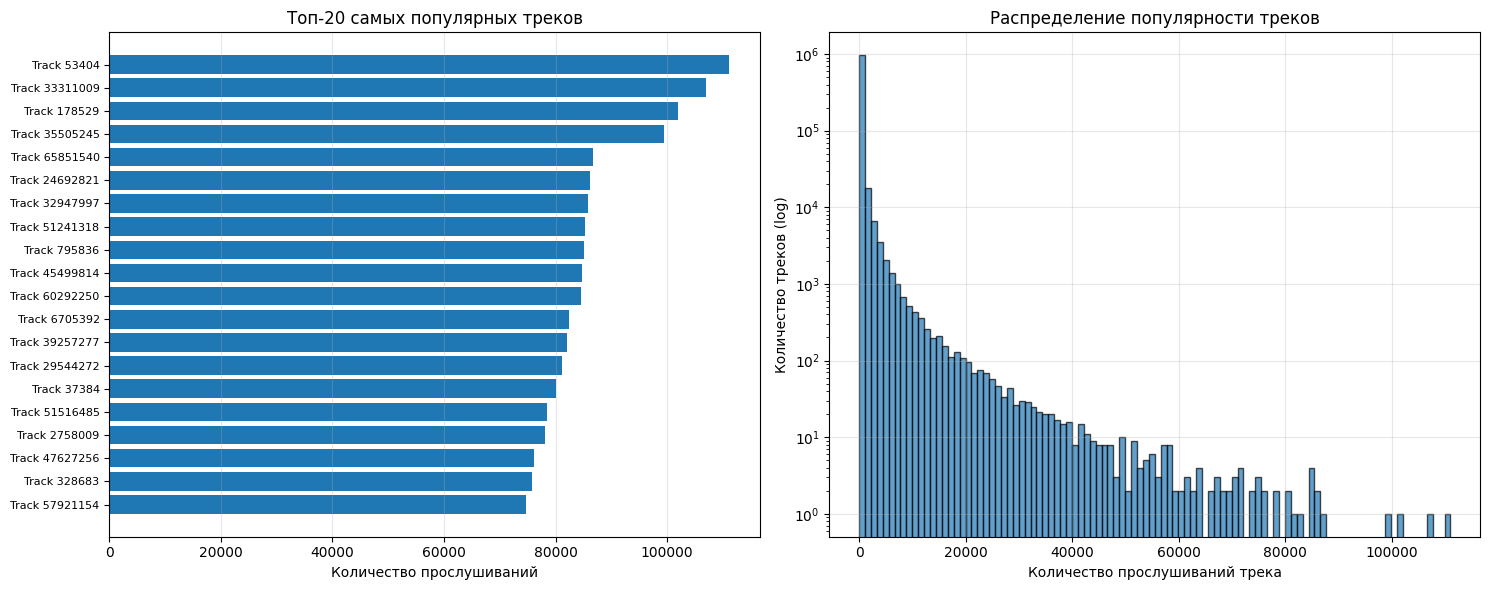


Статистика по популярности треков:
count    1000000.000000
mean         222.629898
std         1369.930708
min            5.000000
25%            9.000000
50%           19.000000
75%           67.000000
max       111062.000000
Name: listen_count, dtype: float64


In [13]:
# Подсчет количества прослушиваний каждого трека
track_popularity = interactions.groupby('track_id').size().reset_index(name='listen_count')
track_popularity = track_popularity.sort_values('listen_count', ascending=False)

print(f"\nТоп-20 самых популярных треков:")
print("-" * 70)

# Получаем информацию о топ треках
top_20_tracks = track_popularity.head(20)

# Объединяем с информацией о треках
top_20_with_info = top_20_tracks.merge(tracks, on='track_id', how='left')

# Получаем названия треков и исполнителей
for idx, row in top_20_with_info.iterrows():
    track_id = row['track_id']
    listen_count = row['listen_count']
    
    # Получаем название трека
    track_name = catalog_names[(catalog_names['id'] == track_id) & 
                                (catalog_names['type'] == 'track')]['name'].values
    track_name = track_name[0] if len(track_name) > 0 else 'Unknown Track'
    
    # Получаем имя исполнителя
    if len(row['artists']) > 0:
        artist_id = row['artists'][0]
        artist_name = catalog_names[(catalog_names['id'] == artist_id) & 
                                     (catalog_names['type'] == 'artist')]['name'].values
        artist_name = artist_name[0] if len(artist_name) > 0 else 'Unknown Artist'
    else:
        artist_name = 'Unknown Artist'
    
    print(f"{idx+1:2d}. {track_name[:40]:40s} - {artist_name[:25]:25s} ({listen_count:,} прослушиваний)")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# График 1: Топ-20 треков
top_20_tracks_plot = top_20_tracks.head(20)
axes[0].barh(range(len(top_20_tracks_plot)), top_20_tracks_plot['listen_count'])
axes[0].set_yticks(range(len(top_20_tracks_plot)))
axes[0].set_yticklabels([f"Track {tid}" for tid in top_20_tracks_plot['track_id']], fontsize=8)
axes[0].set_xlabel('Количество прослушиваний')
axes[0].set_title('Топ-20 самых популярных треков')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# График 2: Распределение популярности треков
axes[1].hist(track_popularity['listen_count'], bins=100, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Количество прослушиваний трека')
axes[1].set_ylabel('Количество треков (log)')
axes[1].set_yscale('log')
axes[1].set_title('Распределение популярности треков')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nСтатистика по популярности треков:")
print(track_popularity['listen_count'].describe())

Наиболее популярные жанры


Топ-20 самых популярных жанров:
 1. Unknown Genre                                      (144,931,874 прослушиваний, 65.10%)
 2. pop                                                (22,780,058 прослушиваний, 10.23%)
 3. dance                                              (14,499,652 прослушиваний, 6.51%)
 4. electronics                                        (11,083,137 прослушиваний, 4.98%)
 5. alternative                                        (7,598,396 прослушиваний, 3.41%)
 6. indie                                              (5,448,861 прослушиваний, 2.45%)
 7. punk                                               (3,534,483 прослушиваний, 1.59%)
 8. shanson                                            (2,189,103 прослушиваний, 0.98%)
 9. rnb                                                (1,919,415 прослушиваний, 0.86%)
10. soundtrack                                         (1,864,717 прослушиваний, 0.84%)
11. estrada                                            (1,396,187 прослушиваний,

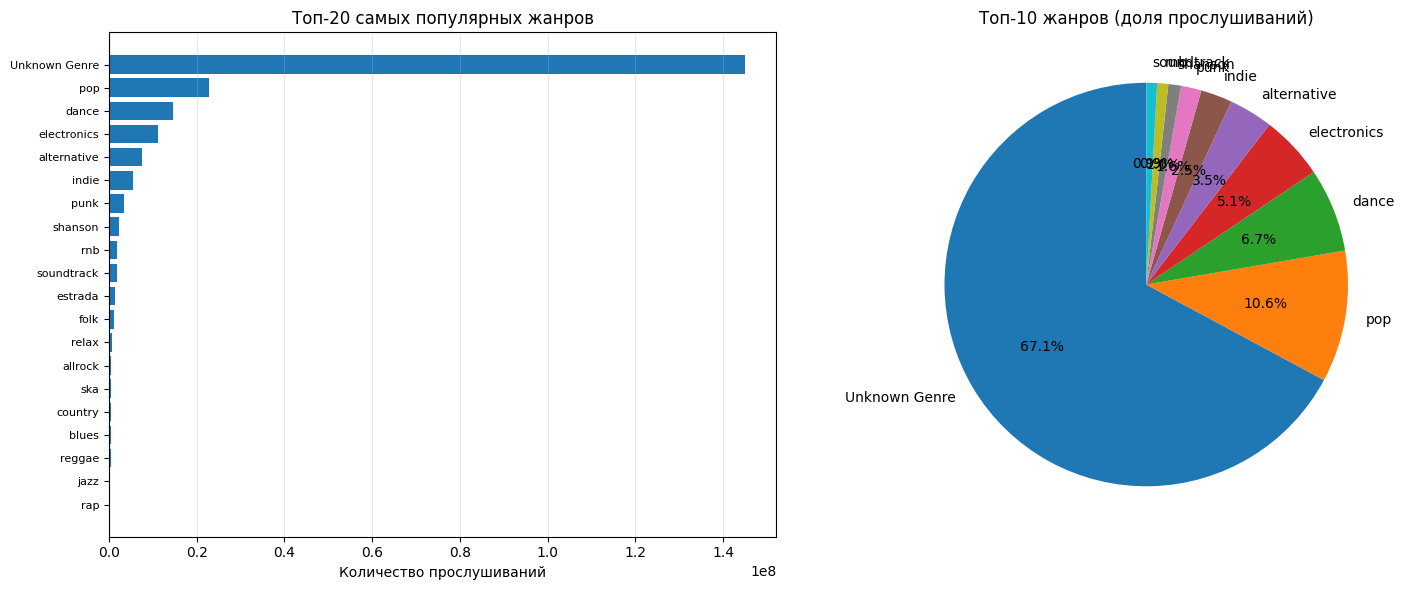

In [14]:
# Собираем все жанры из прослушанных треков
listened_tracks = interactions.merge(tracks[['track_id', 'genres']], on='track_id', how='left')

# Подсчитываем жанры
all_genres = []
for genres_list in listened_tracks['genres']:
    if isinstance(genres_list, list):
        all_genres.extend(genres_list)

genre_counts = Counter(all_genres)
genre_popularity = pd.DataFrame(genre_counts.most_common(20), columns=['genre_id', 'count'])

print(f"\nТоп-20 самых популярных жанров:")

# Получаем названия жанров
for idx, row in genre_popularity.iterrows():
    genre_id = row['genre_id']
    count = row['count']
    
    genre_name = catalog_names[(catalog_names['id'] == genre_id) & 
                                (catalog_names['type'] == 'genre')]['name'].values
    genre_name = genre_name[0] if len(genre_name) > 0 else f'Genre {genre_id}'
    
    percentage = (count / len(listened_tracks)) * 100
    print(f"{idx+1:2d}. {genre_name[:50]:50s} ({count:,} прослушиваний, {percentage:.2f}%)")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# График 1: Топ-20 жанров
top_20_genres = genre_popularity.head(20)
axes[0].barh(range(len(top_20_genres)), top_20_genres['count'])
axes[0].set_yticks(range(len(top_20_genres)))

# Получаем названия для оси Y
genre_labels = []
for genre_id in top_20_genres['genre_id']:
    genre_name = catalog_names[(catalog_names['id'] == genre_id) & 
                                (catalog_names['type'] == 'genre')]['name'].values
    genre_name = genre_name[0][:30] if len(genre_name) > 0 else f'Genre {genre_id}'
    genre_labels.append(genre_name)

axes[0].set_yticklabels(genre_labels, fontsize=8)
axes[0].set_xlabel('Количество прослушиваний')
axes[0].set_title('Топ-20 самых популярных жанров')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# График 2: Pie chart топ-10
top_10_genres = genre_popularity.head(10)
top_10_labels = []
for genre_id in top_10_genres['genre_id']:
    genre_name = catalog_names[(catalog_names['id'] == genre_id) & 
                                (catalog_names['type'] == 'genre')]['name'].values
    genre_name = genre_name[0][:20] if len(genre_name) > 0 else f'Genre {genre_id}'
    top_10_labels.append(genre_name)

axes[1].pie(top_10_genres['count'], labels=top_10_labels, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Топ-10 жанров (доля прослушиваний)')

plt.tight_layout()
plt.show()

Треки, которые никто не прослушал


Общая статистика:
Всего треков в каталоге: 1,000,000
Треков с прослушиваниями: 1,000,000 (100.00%)
Треков без прослушиваний: 0 (0.00%)

Примеры треков без прослушиваний (первые 10):
----------------------------------------------------------------------


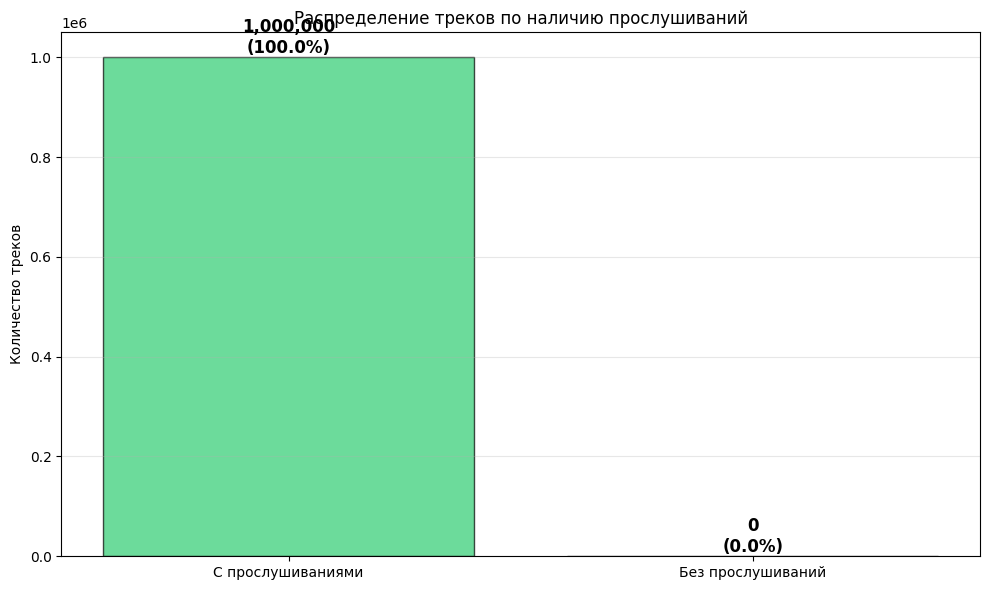

In [15]:
# Находим треки, которые никто не прослушал
listened_track_ids = set(interactions['track_id'].unique())
all_track_ids = set(tracks['track_id'].unique())
unlistened_track_ids = all_track_ids - listened_track_ids

print(f"\nОбщая статистика:")
print(f"Всего треков в каталоге: {len(all_track_ids):,}")
print(f"Треков с прослушиваниями: {len(listened_track_ids):,} ({len(listened_track_ids)/len(all_track_ids)*100:.2f}%)")
print(f"Треков без прослушиваний: {len(unlistened_track_ids):,} ({len(unlistened_track_ids)/len(all_track_ids)*100:.2f}%)")

# Анализ непрослушанных треков
unlistened_tracks = tracks[tracks['track_id'].isin(unlistened_track_ids)]

print(f"\nПримеры треков без прослушиваний (первые 10):")
print("-" * 70)

for idx, row in unlistened_tracks.head(10).iterrows():
    track_id = row['track_id']
    
    # Получаем название трека
    track_name = catalog_names[(catalog_names['id'] == track_id) & 
                                (catalog_names['type'] == 'track')]['name'].values
    track_name = track_name[0] if len(track_name) > 0 else 'Unknown Track'
    
    # Получаем имя исполнителя
    if len(row['artists']) > 0:
        artist_id = row['artists'][0]
        artist_name = catalog_names[(catalog_names['id'] == artist_id) & 
                                     (catalog_names['type'] == 'artist')]['name'].values
        artist_name = artist_name[0] if len(artist_name) > 0 else 'Unknown Artist'
    else:
        artist_name = 'Unknown Artist'
    
    print(f"{track_name[:40]:40s} - {artist_name[:25]:25s}")

# Визуализация
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['С прослушиваниями', 'Без прослушиваний']
values = [len(listened_track_ids), len(unlistened_track_ids)]
colors = ['#2ecc71', '#e74c3c']

bars = ax.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Количество треков')
ax.set_title('Распределение треков по наличию прослушиваний')
ax.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:,}\n({value/len(all_track_ids)*100:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [16]:
items = tracks.copy()

# Добавляем названия треков
track_names = catalog_names[catalog_names['type'] == 'track'][['id', 'name']].rename(
    columns={'id': 'track_id', 'name': 'track_name'}
)
items = items.merge(track_names, on='track_id', how='left')

print(f"Подготовлен датасет items: {items.shape}")
print(f"Колонки: {list(items.columns)}")

print("\nПодготовка events.parquet...")
events = interactions.copy()

print(f"Подготовлен датасет events: {events.shape}")
print(f"Колонки: {list(events.columns)}")

# Настройки S3
S3_BUCKET = 's3-student-mle-20250227-831080ee09'
S3_PATH = 'recsys/data/'

items.to_parquet('items.parquet', index=False)
events.to_parquet('events.parquet', index=False)

Подготовлен датасет items: (1000000, 5)
Колонки: ['track_id', 'albums', 'artists', 'genres', 'track_name']

Подготовка events.parquet...
Подготовлен датасет events: (222629898, 4)
Колонки: ['user_id', 'track_id', 'track_seq', 'started_at']


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [17]:
try:
    s3_client = boto3.client('s3', endpoint_url="https://storage.yandexcloud.net", region_name="ru-central1")
    
    # Сохранение items.parquet
    items_buffer = BytesIO()
    items.to_parquet(items_buffer, index=False)
    items_buffer.seek(0)
    s3_client.upload_fileobj(items_buffer, S3_BUCKET, f'{S3_PATH}items.parquet')
    print(f"items.parquet загружен в s3://{S3_BUCKET}/{S3_PATH}items.parquet")
    
    # Сохранение events.parquet
    events_buffer = BytesIO()
    events.to_parquet(events_buffer, index=False)
    events_buffer.seek(0)
    s3_client.upload_fileobj(events_buffer, S3_BUCKET, f'{S3_PATH}events.parquet')
    print(f"events.parquet загружен в s3://{S3_BUCKET}/{S3_PATH}events.parquet")
    
    print("\nВсе файлы успешно загружены в S3!")
    
except Exception as e:
    print(f"\nОшибка при загрузке в S3: {e}")
    print("Файлы сохранены только локально.")

items.parquet загружен в s3://s3-student-mle-20250227-831080ee09/recsys/data/items.parquet
events.parquet загружен в s3://s3-student-mle-20250227-831080ee09/recsys/data/events.parquet

Все файлы успешно загружены в S3!


# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [ ]:
# по хорошему ресетнуть ядро (можно руками)
%reset

Nothing done.


# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
import boto3
from io import BytesIO

items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

#сокращу датасет для удобства обучения
SAMPLE_FRACTION = 0.15

all_users = events['user_id'].unique()
print(f"\nВсего пользователей: {len(all_users):,}")

# Случайная выборка пользователей
np.random.seed(42)
sampled_users = np.random.choice(all_users, 
                                 size=int(len(all_users) * SAMPLE_FRACTION), 
                                 replace=False)

print(f"Выбрано пользователей: {len(sampled_users):,} ({SAMPLE_FRACTION*100:.0f}%)")

events = events[events['user_id'].isin(sampled_users)].copy()

used_tracks = events['track_id'].unique()
items = items[items['track_id'].isin(used_tracks)].copy()

print(f"\nПосле сокращения:")
print(f"  items: {items.shape}")
print(f"  events: {events.shape}")


/home/mle-user/mle-project-sprint-4-v001/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Всего пользователей: 1,373,221
Выбрано пользователей: 205,983 (15%)

После сокращения:
  items: (872294, 5)
  events: (33232261, 4)


In [2]:
items.head()

,track_id,albums,artists,genres,track_name
1,38,[-1],[16],[-1],Momma's Boy
2,135,[-1],[84],[11],Atticus
4,138,[-1],[84],[11],Don't Upset The Rhythm (Go Baby Go)
5,139,[-1],[84],[11],Wild Young Hearts
6,140,[-1],[84],[11],Sometimes


In [3]:
events.head()

,user_id,track_id,track_seq,started_at
365,5,975,1,2022-05-12
366,5,18686,2,2022-05-12
367,5,18705,3,2022-05-15
368,5,27965,4,2022-05-19
369,5,52100,5,2022-05-20


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [4]:
N_RECOMMENDATIONS = 50
SPLIT_DATE = '2022-12-16'
BATCH_SIZE = 10000

S3_BUCKET = 's3-student-mle-20250227-831080ee09'
S3_PATH = 'recsys/recommendations/'

In [5]:
VALIDATION_DATE = '2022-12-09'
SPLIT_DATE = '2022-12-16'

val_timestamp = pd.to_datetime(VALIDATION_DATE)
split_timestamp = pd.to_datetime(SPLIT_DATE)

train_for_model = events[events['started_at'] < val_timestamp].copy()
validation = events[(events['started_at'] >= val_timestamp) & 
                    (events['started_at'] < split_timestamp)].copy()
test = events[events['started_at'] >= split_timestamp].copy()

print(f"Разбивка данных:")
print(f"  Train (для ALS):  {len(train_for_model):,} ({train_for_model['started_at'].min()} - {train_for_model['started_at'].max()})")
print(f"  Validation:       {len(validation):,} ({validation['started_at'].min()} - {validation['started_at'].max()})")
print(f"  Test:             {len(test):,} ({test['started_at'].min()} - {test['started_at'].max()})")

# Проверка на перекрытия
assert train_for_model['started_at'].max() < validation['started_at'].min(), "Train пересекается с validation!"
assert validation['started_at'].max() < test['started_at'].min(), "Validation пересекается с test!"
print("Проверка: нет перекрытий между train/validation/test")

Разбивка данных:
  Train (для ALS):  29,948,920 (2022-01-01 00:00:00 - 2022-12-08 00:00:00)
  Validation:       1,189,132 (2022-12-09 00:00:00 - 2022-12-15 00:00:00)
  Test:             2,094,209 (2022-12-16 00:00:00 - 2022-12-31 00:00:00)
Проверка: нет перекрытий между train/validation/test


In [6]:
train_users = train_for_model['user_id'].unique()
train_tracks = set(train_for_model['track_id'].unique())

print(f"Уникальные значения в Train (для ALS):")
print(f"  Пользователи: {len(train_users):,}")
print(f"  Треки: {len(train_tracks):,}")

Уникальные значения в Train (для ALS):
  Пользователи: 198,308
  Треки: 840,513


In [7]:
del events
gc.collect()

0

In [8]:
user_encoder = LabelEncoder()
track_encoder = LabelEncoder()

train_for_model['user_idx'] = user_encoder.fit_transform(train_for_model['user_id'])
train_for_model['track_idx'] = track_encoder.fit_transform(train_for_model['track_id'])

interaction_matrix = train_for_model.groupby(['user_idx', 'track_idx']).size().reset_index(name='weight')

user_item_matrix = csr_matrix(
    (interaction_matrix['weight'], 
     (interaction_matrix['user_idx'], interaction_matrix['track_idx'])),
    shape=(train_for_model['user_idx'].nunique(), train_for_model['track_idx'].nunique())
)

print(f"Матрица взаимодействий: {user_item_matrix.shape}")
print(f"  (только train_for_model, БЕЗ validation)")

Матрица взаимодействий: (198308, 840513)
  (только train_for_model, БЕЗ validation)


In [9]:
del interaction_matrix
gc.collect()

0

# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [10]:
track_popularity = train_for_model.groupby('track_id').size().reset_index(name='popularity')
track_popularity = track_popularity.sort_values('popularity', ascending=False)

print(f"Популярность рассчитана по train_for_model (БЕЗ validation)")
print(f"Топ-10 популярных треков:")
for idx, row in track_popularity.head(10).iterrows():
    print(f"  Track {row['track_id']}: {row['popularity']:,} прослушиваний")

Популярность рассчитана по train_for_model (БЕЗ validation)
Топ-10 популярных треков:
  Track 53404: 16,342 прослушиваний
  Track 178529: 14,850 прослушиваний
  Track 33311009: 14,618 прослушиваний
  Track 35505245: 13,995 прослушиваний
  Track 795836: 12,317 прослушиваний
  Track 24692821: 12,273 прослушиваний
  Track 6705392: 11,846 прослушиваний
  Track 37384: 11,745 прослушиваний
  Track 32947997: 11,594 прослушиваний
  Track 29544272: 11,449 прослушиваний


In [11]:
top_tracks = track_popularity.head(N_RECOMMENDATIONS)['track_id'].tolist()
track_pop_dict = track_popularity.set_index('track_id')['popularity'].to_dict()

base_recs = pd.DataFrame({
    'track_id': top_tracks,
    'rank': range(1, len(top_tracks) + 1),
    'score': [track_pop_dict[tid] for tid in top_tracks]
})

print(f"\nСоздание рекомендаций для {len(train_users):,} пользователей...")

all_batches = []
for i in tqdm(range(0, len(train_users), BATCH_SIZE), desc="Батчи"):
    batch_users = train_users[i:i+BATCH_SIZE]
    
    # Создаем рекомендации для батча
    batch_recs = []
    for user_id in batch_users:
        user_recs = base_recs.copy()
        user_recs['user_id'] = user_id
        batch_recs.append(user_recs)
    
    batch_df = pd.concat(batch_recs, ignore_index=True)
    all_batches.append(batch_df)
    
    # Периодически очищаем память
    if len(all_batches) >= 10:
        temp_df = pd.concat(all_batches, ignore_index=True)
        all_batches = [temp_df]
        gc.collect()

# Объединяем все батчи
top_popular_df = pd.concat(all_batches, ignore_index=True)
top_popular_df = top_popular_df[['user_id', 'track_id', 'rank', 'score']]

print(f"\nСоздано: {len(top_popular_df):,} рекомендаций")
print(f"  Пользователей: {top_popular_df['user_id'].nunique()}")
print(f"  Уникальных треков: {top_popular_df['track_id'].nunique()}")


Создание рекомендаций для 198,308 пользователей...


Батчи: 100%|██████████| 20/20 [00:41<00:00,  2.08s/it]



Создано: 9,915,400 рекомендаций
  Пользователей: 198308
  Уникальных треков: 50


In [12]:
top_popular_df.to_parquet('top_popular.parquet', index=False)

try:
    s3_client = boto3.client('s3', endpoint_url="https://storage.yandexcloud.net", region_name="ru-central1")
    
    # Сохранение top_popular.parquet
    top_popular_buffer = BytesIO()
    top_popular_df.to_parquet(top_popular_buffer, index=False)
    top_popular_buffer.seek(0)
    s3_client.upload_fileobj(top_popular_buffer, S3_BUCKET, f'{S3_PATH}top_popular.parquet')
    print(f"top_popular.parquet загружен в s3://{S3_BUCKET}/{S3_PATH}top_popular.parquet")
    
    print("\nВсе файлы успешно загружены в S3!")
    
except Exception as e:
    print(f"\nОшибка при загрузке в S3: {e}")
    print("Файлы сохранены только локально.")

top_popular.parquet загружен в s3://s3-student-mle-20250227-831080ee09/recsys/recommendations/top_popular.parquet

Все файлы успешно загружены в S3!


In [13]:
del top_popular_df, all_batches, base_recs, batch_recs, batch_df
gc.collect()

48

# Персональные

Рассчитаем персональные рекомендации.

In [14]:
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares(
    factors=32,
    regularization=0.05,
    iterations=10,
    random_state=42
)

als_model.fit(user_item_matrix)

/home/mle-user/mle-project-sprint-4-v001/.venv/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 10/10 [00:42<00:00,  4.25s/it]


In [15]:
num_users = user_item_matrix.shape[0]
print(f"Обработка {num_users:,} пользователей...")

# Предварительные маппинги избегаю медленных inverse_transform для айдишниуов
user_ids_array = user_encoder.classes_
track_ids_array = track_encoder.classes_

# Предварительное выделение памяти (примерно)
estimated_size = num_users * N_RECOMMENDATIONS
all_user_ids = np.empty(estimated_size, dtype=user_ids_array.dtype)
all_track_ids = np.empty(estimated_size, dtype=track_ids_array.dtype)
all_ranks = np.empty(estimated_size, dtype=np.int16)
all_scores = np.empty(estimated_size, dtype=np.float32)

current_idx = 0

# Векторизованная обработка с минимальными операциями
for user_idx in tqdm(range(num_users), desc="ALS оптим", unit="user", miniters=100):
    try:
        track_indices, scores = als_model.recommend(
            user_idx, 
            user_item_matrix[user_idx],
            N=N_RECOMMENDATIONS,
            filter_already_liked_items=True,
            recalculate_user=False
        )
        
        n_recs = len(track_indices)
        end_idx = current_idx + n_recs
        
        all_user_ids[current_idx:end_idx] = user_ids_array[user_idx]
        all_track_ids[current_idx:end_idx] = track_ids_array[track_indices]
        all_ranks[current_idx:end_idx] = np.arange(1, n_recs + 1, dtype=np.int16)
        all_scores[current_idx:end_idx] = scores.astype(np.float32)
        
        current_idx = end_idx
        
    except:
        continue

all_user_ids = all_user_ids[:current_idx]
all_track_ids = all_track_ids[:current_idx]
all_ranks = all_ranks[:current_idx]
all_scores = all_scores[:current_idx]

print("\nСоздание DataFrame...")
personal_als_df = pd.DataFrame({
    'user_id': all_user_ids,
    'track_id': all_track_ids,
    'rank': all_ranks,
    'score': all_scores
})

personal_als_df['user_id'] = personal_als_df['user_id'].astype('int32')
personal_als_df['track_id'] = personal_als_df['track_id'].astype('int32')
personal_als_df['rank'] = personal_als_df['rank'].astype('int16')
personal_als_df['score'] = personal_als_df['score'].astype('float32')

print(f"Создано: {len(personal_als_df):,} рекомендаций")
print(f"Память: {personal_als_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Обработка 198,308 пользователей...


ALS оптим: 100%|██████████| 198308/198308 [19:57<00:00, 165.56user/s]


Создание DataFrame...
Создано: 9,915,400 рекомендаций
Память: 132.38 MB


In [16]:
personal_als_df.to_parquet('personal_als.parquet', index=False)

try:
    s3_client = boto3.client('s3', endpoint_url="https://storage.yandexcloud.net", region_name="ru-central1")
    
    # Сохранение personal_als.parquet
    personal_als_df_buffer = BytesIO()
    personal_als_df.to_parquet(personal_als_df_buffer, index=False)
    personal_als_df_buffer.seek(0)
    s3_client.upload_fileobj(personal_als_df_buffer, S3_BUCKET, f'{S3_PATH}personal_als.parquet')
    print(f"personal_als.parquet загружен в s3://{S3_BUCKET}/{S3_PATH}personal_als.parquet")
    
    print("\nВсе файлы успешно загружены в S3!")
    
except Exception as e:
    print(f"\nОшибка при загрузке в S3: {e}")
    print("Файлы сохранены только локально.")

personal_als.parquet загружен в s3://s3-student-mle-20250227-831080ee09/recsys/recommendations/personal_als.parquet

Все файлы успешно загружены в S3!


In [17]:
del all_user_ids, all_track_ids, all_ranks, all_scores 
gc.collect()

1484

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [18]:
top_tracks_for_similar = track_popularity.head(1000)['track_id'].tolist()

similar_tracks_dict = {}

for track_id in tqdm(top_tracks_for_similar, desc="Похожие треки"):
    if track_id in track_encoder.classes_:
        track_idx = track_encoder.transform([track_id])[0]
        similar_indices, scores = als_model.similar_items(track_idx, N=50)
        similar_ids = track_encoder.inverse_transform(similar_indices)
        similar_tracks_dict[track_id] = list(zip(similar_ids, scores))

Похожие треки:   0%|          | 0/1000 [00:00<?, ?it/s]

Похожие треки: 100%|██████████| 1000/1000 [00:35<00:00, 28.24it/s]


In [19]:
similar_recs = []
for source_track_id, similar_list in tqdm(similar_tracks_dict.items(), desc="Формирование"):
    for rank, (similar_track_id, score) in enumerate(similar_list, 1):
        similar_recs.append({
            'track_id': source_track_id,
            'similar_track_id': similar_track_id,
            'rank': rank,
            'score': float(score)
        })

similar_df = pd.DataFrame(similar_recs)
similar_df.to_parquet('similar.parquet', index=False)

Формирование: 100%|██████████| 1000/1000 [00:00<00:00, 30849.54it/s]


In [20]:
try:
    s3_client = boto3.client('s3', endpoint_url="https://storage.yandexcloud.net", region_name="ru-central1")
    buffer = BytesIO()
    similar_df.to_parquet(buffer, index=False)
    buffer.seek(0)
    s3_client.upload_fileobj(buffer, S3_BUCKET, f'{S3_PATH}similar.parquet')
    print(f"Загружено в S3")
except Exception as e:
    print(f"\nОшибка при загрузке в S3: {e}")
    print("Файлы сохранены только локально.")

Загружено в S3


In [21]:
del similar_recs, similar_tracks_dict, similar_df
gc.collect()

1448

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [22]:
candidates = personal_als_df.copy()

In [23]:
# больше всего мне интересно протестить много признаков поэтому тут приведу их, потому что понятно ALS работает, а вот ранжирование уже более интересная вещь =)

import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
import gc

candidates = personal_als_df.copy()

# Popularity
candidates['track_popularity'] = candidates['track_id'].map(track_pop_dict).fillna(0)

# Genres и Artists
track_genres_count = items[['track_id', 'genres']].copy()
track_genres_count['genres_count'] = track_genres_count['genres'].apply(len)
genres_dict = track_genres_count.set_index('track_id')['genres_count'].to_dict()
candidates['genres_count'] = candidates['track_id'].map(genres_dict).fillna(1)
track_artists_count = items[['track_id', 'artists']].copy()

track_artists_count['artists_count'] = track_artists_count['artists'].apply(len)
artists_dict = track_artists_count.set_index('track_id')['artists_count'].to_dict()
candidates['artists_count'] = candidates['track_id'].map(artists_dict).fillna(1)

# Логарифмы (помогают с распределением)
candidates['log_popularity'] = np.log1p(candidates['track_popularity'])
candidates['log_score'] = np.log1p(candidates['score'])

# Нормализация popularity (по всему датасету)
pop_mean = candidates['track_popularity'].mean()
pop_std = candidates['track_popularity'].std()
candidates['popularity_normalized'] = (candidates['track_popularity'] - pop_mean) / (pop_std + 1e-5)

# Квадраты и корни (нелинейность)
candidates['score_squared'] = candidates['score'] ** 2
candidates['score_sqrt'] = np.sqrt(candidates['score'])

# Статистики по пользователю из train
print("  Вычисление статистик из train...")
user_train_stats = train_for_model.groupby('user_id').agg({
    'track_id': 'count',
}).rename(columns={'track_id': 'user_total_listens'}).reset_index()

candidates = candidates.merge(user_train_stats, on='user_id', how='left')
candidates['user_total_listens'] = candidates['user_total_listens'].fillna(0)

# Средняя популярность треков, которые слушал пользователь
train_with_pop = train_for_model.merge(items[['track_id']], on='track_id', how='left')
train_with_pop['track_popularity'] = train_with_pop['track_id'].map(track_pop_dict).fillna(0)
user_pop_stats = train_with_pop.groupby('user_id')['track_popularity'].agg(['mean', 'median']).reset_index()
user_pop_stats.columns = ['user_id', 'user_avg_popularity', 'user_median_popularity']

candidates = candidates.merge(user_pop_stats, on='user_id', how='left')
candidates['user_avg_popularity'] = candidates['user_avg_popularity'].fillna(pop_mean)
candidates['user_median_popularity'] = candidates['user_median_popularity'].fillna(pop_mean)

# Статистики ALS score по пользователю
user_score_stats = candidates.groupby('user_id')['score'].agg(['mean', 'std', 'min', 'max']).reset_index()
user_score_stats.columns = ['user_id', 'user_mean_score', 'user_std_score', 'user_min_score', 'user_max_score']
candidates = candidates.merge(user_score_stats, on='user_id', how='left')
candidates['user_std_score'] = candidates['user_std_score'].fillna(0)

# Отклонение от пользовательских предпочтений
candidates['popularity_vs_user_avg'] = candidates['track_popularity'] - candidates['user_avg_popularity']
candidates['popularity_vs_user_median'] = candidates['track_popularity'] - candidates['user_median_popularity']

# Относительная позиция score
candidates['score_vs_user_mean'] = candidates['score'] - candidates['user_mean_score']
candidates['score_vs_user_max'] = candidates['score'] / (candidates['user_max_score'] + 1e-5)
candidates['score_vs_user_min'] = candidates['score'] / (candidates['user_min_score'] + 1e-5)

# Ratio признаки
candidates['score_to_pop_ratio'] = candidates['score'] / (candidates['track_popularity'] + 1)
candidates['score_to_log_pop_ratio'] = candidates['score'] / (candidates['log_popularity'] + 1)

# Score × Popularity
candidates['score_x_popularity'] = candidates['score'] * candidates['log_popularity']
candidates['score_x_pop_normalized'] = candidates['score'] * candidates['popularity_normalized']

# Score × Genres/Artists
candidates['score_x_genres'] = candidates['score'] * candidates['genres_count']
candidates['score_x_artists'] = candidates['score'] * candidates['artists_count']

# Popularity × User preference
candidates['pop_x_user_pop'] = candidates['track_popularity'] * candidates['user_avg_popularity']

# Нормализованный ранг (от 0 до 1)
candidates['rank_normalized'] = candidates['rank'] / candidates.groupby('user_id')['rank'].transform('max')
candidates['rank_log'] = np.log1p(candidates['rank'])

# Квантили ранга
candidates['rank_quartile'] = pd.qcut(candidates['rank'], q=4, labels=[1, 2, 3, 4], duplicates='drop').astype(int)

# Редкость трека (обратная популярность)
max_pop = candidates['track_popularity'].max()
candidates['track_rarity'] = max_pop / (candidates['track_popularity'] + 1)
candidates['log_rarity'] = np.log1p(candidates['track_rarity'])

# Новизна для пользователя (насколько трек отличается от обычных предпочтений)
candidates['novelty_score'] = np.abs(candidates['popularity_vs_user_avg']) / (candidates['user_avg_popularity'] + 1)

# Сколько раз трек был прослушан в train
track_listen_counts = train_for_model.groupby('track_id').size().reset_index(name='track_listen_count')
candidates = candidates.merge(track_listen_counts, on='track_id', how='left')
candidates['track_listen_count'] = candidates['track_listen_count'].fillna(0)

# Сколько уникальных пользователей слушали этот трек
track_unique_users = train_for_model.groupby('track_id')['user_id'].nunique().reset_index(name='track_unique_listeners')
candidates = candidates.merge(track_unique_users, on='track_id', how='left')
candidates['track_unique_listeners'] = candidates['track_unique_listeners'].fillna(0)

feature_columns = [
    # Базовые
    'score',
    'track_popularity',
    'genres_count',
    'artists_count',
    
    # Преобразования
    'log_popularity',
    'log_score',
    'popularity_normalized',
    'score_squared',
    'score_sqrt',
    
    # Пользовательские
    'user_total_listens',
    'user_avg_popularity',
    'user_median_popularity',
    'user_mean_score',
    'user_std_score',
    'user_min_score',
    'user_max_score',
    
    # Относительные
    'popularity_vs_user_avg',
    'popularity_vs_user_median',
    'score_vs_user_mean',
    'score_vs_user_max',
    'score_vs_user_min',
    'score_to_pop_ratio',
    'score_to_log_pop_ratio',
    
    # Взаимодействия
    'score_x_popularity',
    'score_x_pop_normalized',
    'score_x_genres',
    'score_x_artists',
    'pop_x_user_pop',
    
    # Позиционные (без утечки)
    'rank_normalized',
    'rank_log',
    'rank_quartile',
    
    # Diversity
    'track_rarity',
    'log_rarity',
    'novelty_score',
    
    # Статистики треков
    'track_listen_count',
    'track_unique_listeners'
]

print(f"ВСЕГО ПРИЗНАКОВ: {len(feature_columns)}")

  Вычисление статистик из train...
ВСЕГО ПРИЗНАКОВ: 36


# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [24]:
from sklearn.model_selection import train_test_split

# train_for_model и validation уже созданы
# Повторное разбиение НЕ НУЖНО

val_interactions = validation[['user_id', 'track_id']].drop_duplicates()
val_interactions['target'] = 1

candidates = candidates.merge(val_interactions, on=['user_id', 'track_id'], how='left')
candidates['target'] = candidates['target'].fillna(0).astype(int)

positive_ratio = candidates['target'].mean()
print(f"\nЦелевая переменная:")
print(f"  Позитивная доля: {positive_ratio*100:.4f}%")
print(f"  Позитивных: {candidates['target'].sum():,}")
print(f"  Негативных: {(candidates['target']==0).sum():,}")

# Проверка: есть ли пользователи и из train, и из validation
train_users_set = set(train_for_model['user_id'].unique())
val_users_set = set(validation['user_id'].unique())
overlap_users = train_users_set & val_users_set
print(f"\nПользователей в train_for_model: {len(train_users_set):,}")
print(f"Пользователей в validation: {len(val_users_set):,}")
print(f"Пересечение: {len(overlap_users):,}")


Целевая переменная:
  Позитивная доля: 0.4033%
  Позитивных: 39,992
  Негативных: 9,875,408

Пользователей в train_for_model: 198,308
Пользователей в validation: 111,705
Пересечение: 108,530


In [25]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score 

X = candidates[feature_columns].fillna(0)
y = candidates['target']
print(y)
# Проверка на inf
X = X.replace([np.inf, -np.inf], 0)

print(f"\nФорма данных: {X.shape}")
print(f"NaN в данных: {X.isna().sum().sum()}")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

ranker = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    l2_leaf_reg=3,
    random_seed=42,
    verbose=50,
    early_stopping_rounds=50,
    auto_class_weights='Balanced',
    task_type='CPU',
    thread_count=-1
)

ranker.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    plot=False
)

y_train_pred = ranker.predict_proba(X_train)[:, 1]
y_val_pred = ranker.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(y_train, y_train_pred)
val_auc = roc_auc_score(y_val, y_val_pred)

print(f"\nМетрики:")
print(f"  Train AUC: {train_auc:.4f}")
print(f"  Val AUC:   {val_auc:.4f}")

feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': ranker.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_importance.head(20).iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:7.2f}")

# Проверка: сколько признаков реально работают
working_features = (feature_importance['importance'] > 0.1).sum()
print(f"\nПризнаков с importance > 0.1: {working_features}")

candidates['ranking_score'] = ranker.predict_proba(X)[:, 1]

# Диагностика
print(f"\nСтатистика ranking_score:")
print(f"  Min:  {candidates['ranking_score'].min():.6f}")
print(f"  Max:  {candidates['ranking_score'].max():.6f}")
print(f"  Mean: {candidates['ranking_score'].mean():.6f}")
print(f"  Std:  {candidates['ranking_score'].std():.6f}")

# Корреляция с ALS
corr_als = candidates['score'].corr(candidates['ranking_score'])
corr_pop = candidates['track_popularity'].corr(candidates['ranking_score'])
corr_rank = candidates['rank'].corr(candidates['ranking_score'])

print(f"\nКорреляции:")
print(f"  с ALS score:        {corr_als:.4f}")
print(f"  с popularity:       {corr_pop:.4f}")
print(f"  с исходным rank:    {corr_rank:.4f}")

if candidates['ranking_score'].std() < 0.001:
    print("\n⚠️ ВНИМАНИЕ: Очень низкий std! Модель плохо различает объекты.")
elif abs(corr_rank) > 0.95:
    print("\n⚠️ ВНИМАНИЕ: Слишком высокая корреляция с rank - утечка данных!")
else:
    print("\n✓ Ранжирование выглядит нормально!")

# Пример изменения
sample_user = candidates['user_id'].iloc[0]
sample = candidates[candidates['user_id'] == sample_user].sort_values('rank').head(20)
sample['new_rank'] = sample['ranking_score'].rank(ascending=False, method='first').astype(int)

print(f"\nПример пользователя {sample_user}:")
print(sample[['track_id', 'rank', 'score', 'ranking_score', 'new_rank']].head(10))

changes = (sample['rank'] != sample['new_rank']).sum()
print(f"Изменено рангов: {changes} из {len(sample)}")


0          0
1          0
2          0
3          0
4          0
          ..
9915395    0
9915396    0
9915397    0
9915398    0
9915399    0
Name: target, Length: 9915400, dtype: int64

Форма данных: (9915400, 36)
NaN в данных: 0
0:	test: 0.6914550	best: 0.6914550 (0)	total: 1.34s	remaining: 11m 7s
50:	test: 0.7170593	best: 0.7170593 (50)	total: 57.8s	remaining: 8m 29s
100:	test: 0.7257825	best: 0.7257825 (100)	total: 1m 50s	remaining: 7m 15s
150:	test: 0.7308773	best: 0.7308773 (150)	total: 2m 44s	remaining: 6m 19s
200:	test: 0.7350066	best: 0.7350066 (200)	total: 3m 38s	remaining: 5m 24s
250:	test: 0.7376887	best: 0.7376887 (250)	total: 4m 32s	remaining: 4m 30s
300:	test: 0.7402947	best: 0.7402947 (300)	total: 5m 28s	remaining: 3m 37s
350:	test: 0.7437941	best: 0.7437941 (350)	total: 6m 22s	remaining: 2m 42s
400:	test: 0.7467725	best: 0.7467725 (400)	total: 7m 17s	remaining: 1m 47s
450:	test: 0.7489705	best: 0.7489823 (449)	total: 8m 12s	remaining: 53.5s
499:	test: 0.7502861	best: 

In [26]:
# Очистка
del X, y, X_train, X_val, y_train, y_val
del user_train_stats, user_pop_stats, user_score_stats
del track_listen_counts, track_unique_users
gc.collect()

0

In [27]:
final_recs = []

for user_id in tqdm(candidates['user_id'].unique(), desc="Ранжирование"):
    user_recs = candidates[candidates['user_id'] == user_id].nlargest(N_RECOMMENDATIONS, 'ranking_score')
    user_recs = user_recs.reset_index(drop=True)
    user_recs['final_rank'] = range(1, len(user_recs) + 1)
    final_recs.append(user_recs[['user_id', 'track_id', 'final_rank', 'ranking_score']])

recommendations_df = pd.concat(final_recs, ignore_index=True)
recommendations_df = recommendations_df.rename(columns={'final_rank': 'rank', 'ranking_score': 'score'})

print(f"\nСоздано: {len(recommendations_df):,} итоговых рекомендаций")

# Сохранение
recommendations_df.to_parquet('recommendations.parquet', index=False)

Ранжирование:   0%|          | 0/198308 [00:00<?, ?it/s]

Ранжирование: 100%|██████████| 198308/198308 [23:08<00:00, 142.87it/s]



Создано: 9,915,400 итоговых рекомендаций


In [28]:
try:
    s3_client = boto3.client('s3', endpoint_url="https://storage.yandexcloud.net", region_name="ru-central1")
    buffer = BytesIO()
    recommendations_df.to_parquet(buffer, index=False)
    buffer.seek(0)
    s3_client.upload_fileobj(buffer, S3_BUCKET, f'{S3_PATH}recommendations.parquet')
    print(f"Загружено в S3")
except Exception as e:
    print(f"Ошибка S3: {e}")

Загружено в S3


In [29]:
del candidates, final_recs
gc.collect()

1595

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [40]:
# по шести метрикам: recall, precision, NDCG, MAP, coverage, novelty.

import numpy as np
import pandas as pd
from tqdm import tqdm

def calculate_all_metrics(recommendations, test_data, k=50):
    """
    Расчет всех метрик для оценки качества рекомендаций
    
    Метрики:
    1. Recall@k - доля найденных релевантных треков (set-based)
    2. Precision@k - точность рекомендаций (set-based)
    3. NDCG@k - нормализованный DCG, учитывает порядок (rank-aware)
    4. MAP@k - средняя точность, учитывает порядок (rank-aware)
    5. Coverage - доля уникальных треков в рекомендациях
    6. Novelty - средняя неожиданность рекомендаций (больше = менее популярные треки)
    
    Parameters:
    -----------
    recommendations : pd.DataFrame
        DataFrame с рекомендациями, должен содержать колонки:
        - user_id: идентификатор пользователя
        - track_id: идентификатор трека
        - rank: позиция трека в рекомендациях (1, 2, 3, ...)
    
    test_data : pd.DataFrame
        Тестовые данные с реальными взаимодействиями, должен содержать:
        - user_id: идентификатор пользователя
        - track_id: идентификатор трека
    
    k : int
        Количество топ-рекомендаций для оценки (по умолчанию 50)
    
    Returns:
    --------
    dict : Словарь с рассчитанными метриками
    """
    
    # ===== ПОДГОТОВКА ДАННЫХ =====
    
    # Убираем дубликаты в тесте (один user-track = один факт взаимодействия)
    test_interactions = test_data[['user_id', 'track_id']].drop_duplicates()
    
    # Группируем тест по пользователям (для каждого юзера - set релевантных треков)
    test_grouped = test_interactions.groupby('user_id')['track_id'].apply(set).to_dict()
    
    # Фильтруем рекомендации: берем только топ-k
    recs_topk = recommendations[recommendations['rank'] <= k].copy()
    
    # Группируем рекомендации по пользователям (для каждого юзера - list треков по порядку)
    recs_grouped = recs_topk.groupby('user_id')['track_id'].apply(list).to_dict()
    
    # ===== ИНИЦИАЛИЗАЦИЯ =====
    
    recalls = []          # Recall для каждого пользователя
    precisions = []       # Precision для каждого пользователя
    ndcgs = []           # NDCG для каждого пользователя
    aps = []             # Average Precision для каждого пользователя
    recommended_tracks = set()  # Все уникальные рекомендованные треки (для coverage)
    
    # ===== РАСЧЕТ МЕТРИК ДЛЯ КАЖДОГО ПОЛЬЗОВАТЕЛЯ =====
    
    for user_id in tqdm(test_grouped.keys(), desc=f"Метрики @{k}", leave=False):
        # Пропускаем пользователей, для которых нет рекомендаций
        if user_id not in recs_grouped:
            continue
        
        # Релевантные треки для этого пользователя (из теста)
        relevant = test_grouped[user_id]
        
        # Рекомендованные треки для этого пользователя (топ-k)
        recommended = recs_grouped[user_id][:k]
        
        # Добавляем в общий набор для coverage
        recommended_tracks.update(recommended)
        
        # ===== 1. RECALL@k и PRECISION@k (не учитывают порядок) =====
        
        # Сколько релевантных треков попало в рекомендации
        hits = len(relevant & set(recommended))
        
        # Recall = найденные релевантные / все релевантные
        recall = hits / len(relevant) if len(relevant) > 0 else 0
        recalls.append(recall)
        
        # Precision = найденные релевантные / все рекомендованные
        precision = hits / k if k > 0 else 0
        precisions.append(precision)
        
        # ===== 2. NDCG@k (учитывает порядок - чем выше релевантный трек, тем лучше) =====
        
        # DCG (Discounted Cumulative Gain)
        dcg = 0
        for i, track_id in enumerate(recommended):
            if track_id in relevant:
                # Релевантность = 1 (трек релевантен)
                # Дисконтирование по позиции: 1 / log2(position + 1)
                # i=0 -> position=1 -> log2(2)=1
                # i=1 -> position=2 -> log2(3)≈1.58
                dcg += 1 / np.log2(i + 2)
        
        # IDCG (Ideal DCG) - если бы все релевантные были в начале списка
        ideal_positions = min(len(relevant), k)
        idcg = sum([1 / np.log2(i + 2) for i in range(ideal_positions)])
        
        # NDCG = DCG / IDCG (нормализация к [0, 1])
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcgs.append(ndcg)
        
        # ===== 3. MAP (Mean Average Precision) - учитывает порядок =====
        
        # Считаем precision на каждой позиции, где был hit
        precisions_at_i = []
        num_hits = 0
        
        for i, track_id in enumerate(recommended):
            if track_id in relevant:
                num_hits += 1
                # Precision на позиции i = (количество hits до i+1) / (i+1)
                precision_at_i = num_hits / (i + 1)
                precisions_at_i.append(precision_at_i)
        
        # Average Precision для этого пользователя
        ap = np.mean(precisions_at_i) if precisions_at_i else 0
        aps.append(ap)
    
    # ===== 4. COVERAGE (разнообразие каталога в рекомендациях) =====
    
    # Доля уникальных треков из каталога, которые были рекомендованы
    coverage = len(recommended_tracks) / len(train_tracks) if len(train_tracks) > 0 else 0
    
    # ===== 5. NOVELTY (неожиданность/новизна рекомендаций) =====
    
    # Подготовка: нормализуем популярность к вероятностям
    track_pop_norm = track_popularity.copy()
    total_popularity = track_pop_norm['popularity'].sum()
    track_pop_norm['pop_prob'] = track_pop_norm['popularity'] / total_popularity
    pop_dict_norm = track_pop_norm.set_index('track_id')['pop_prob'].to_dict()
    
    # Для каждого рекомендованного трека считаем информацию (self-information)
    # Информация = -log2(вероятность)
    # Чем реже трек, тем больше информации он несет
    novelties = []
    for track_id in recommended_tracks:
        pop_prob = pop_dict_norm.get(track_id, 1e-10)  # Маленькая вероятность для неизвестных
        # Self-information: -log2(p)
        # Популярный трек (p=0.1) -> info = 3.32
        # Редкий трек (p=0.001) -> info = 9.97
        information = -np.log2(pop_prob) if pop_prob > 0 else 0
        novelties.append(information)
    
    # Средняя информация = средняя новизна
    novelty = np.mean(novelties) if novelties else 0
    
    # ===== УСРЕДНЕНИЕ И ВОЗВРАТ =====
    
    return {
        # Set-based метрики (порядок не важен)
        'recall@k': np.mean(recalls) if recalls else 0,
        'precision@k': np.mean(precisions) if precisions else 0,
        
        # Rank-aware метрики (порядок важен)
        'ndcg@k': np.mean(ndcgs) if ndcgs else 0,
        'map@k': np.mean(aps) if aps else 0,
        
        # Diversity метрики
        'coverage': coverage,
        'novelty': novelty
    }
    
    
def analyze_recommendations_quality(recommendations, test_data, k=50):
    """
    Дополнительный анализ качества рекомендаций
    """
    print(f"\n{'='*60}")
    print(f"АНАЛИЗ РЕКОМЕНДАЦИЙ @{k}")
    print(f"{'='*60}")
    
    # Базовая статистика
    print(f"\nБазовая статистика:")
    print(f"  Рекомендаций всего: {len(recommendations):,}")
    print(f"  Уникальных пользователей: {recommendations['user_id'].nunique():,}")
    print(f"  Уникальных треков: {recommendations['track_id'].nunique():,}")
    print(f"  Среднее рекомендаций на пользователя: {len(recommendations) / recommendations['user_id'].nunique():.1f}")
    
    # Проверка на дубликаты
    duplicates = recommendations.duplicated(subset=['user_id', 'track_id']).sum()
    if duplicates > 0:
        print(f"\n⚠️ ВНИМАНИЕ: Найдено {duplicates:,} дубликатов (user_id, track_id)!")
    else:
        print(f"\n✅ Дубликатов нет")
    
    # Проверка ранков
    max_rank = recommendations['rank'].max()
    min_rank = recommendations['rank'].min()
    print(f"\nРанки:")
    print(f"  Min rank: {min_rank}")
    print(f"  Max rank: {max_rank}")
    if min_rank != 1:
        print(f"  ⚠️ ВНИМАНИЕ: Min rank должен быть 1!")
    
    # Распределение по пользователям
    user_counts = recommendations.groupby('user_id').size()
    print(f"\nРекомендаций на пользователя:")
    print(f"  Min: {user_counts.min()}")
    print(f"  Max: {user_counts.max()}")
    print(f"  Mean: {user_counts.mean():.1f}")
    print(f"  Median: {user_counts.median():.1f}")
    
    # Покрытие пользователей из теста
    test_users = set(test_data['user_id'].unique())
    rec_users = set(recommendations['user_id'].unique())
    coverage_users = len(rec_users & test_users) / len(test_users) if len(test_users) > 0 else 0
    print(f"\nПокрытие пользователей из теста:")
    print(f"  В тесте: {len(test_users):,}")
    print(f"  В рекомендациях: {len(rec_users):,}")
    print(f"  Пересечение: {len(rec_users & test_users):,} ({coverage_users*100:.1f}%)")
    
    if coverage_users < 0.5:
        print(f"  ⚠️ ВНИМАНИЕ: Меньше 50% пользователей из теста покрыто рекомендациями!")
    
    print(f"\n{'='*60}\n")

In [41]:
top_pop = pd.read_parquet('top_popular.parquet')
als_recs = personal_als_df
final_recs = recommendations_df

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

In [42]:
K = N_RECOMMENDATIONS

methods = {
    'Топ популярные': top_pop,
    'ALS персональные': als_recs,
    'Итоговые (ранжирование)': final_recs
}

all_results = []

# Расчет метрик для каждого метода
for method_name, recs in methods.items():
    print(f"\n{'─'*80}")
    print(f"{method_name}")
    print(f"{'─'*80}")
    
    # Проверка качества рекомендаций перед расчетом метрик
    analyze_recommendations_quality(recs, test, k=K)
    
    # Расчет метрик
    metrics = calculate_all_metrics(recs, test, k=K)
    
    # Вывод метрик с пояснениями
    print(f"\n РЕЗУЛЬТАТЫ:")
    print(f"\n  Set-based метрики (не учитывают порядок):")
    print(f"    Recall@{K}:     {metrics['recall@k']:.4f}  ← Доля найденных релевантных треков")
    print(f"    Precision@{K}:  {metrics['precision@k']:.4f}  ← Точность рекомендаций")
    
    print(f"\n  Rank-aware метрики (учитывают порядок):")
    print(f"    NDCG@{K}:       {metrics['ndcg@k']:.4f}  ← Качество ранжирования")
    print(f"    MAP@{K}:        {metrics['map@k']:.4f}  ← Средняя точность с учетом порядка")
    
    print(f"\n  Diversity метрики:")
    print(f"    Coverage:       {metrics['coverage']:.4f}  ← Доля каталога в рекомендациях")
    print(f"    Novelty:        {metrics['novelty']:.2f}  ← Неожиданность (выше = менее популярные)")
    
    # Сохранение результатов
    all_results.append({
        'Метод': method_name,
        f'Recall@{K}': metrics['recall@k'],
        f'Precision@{K}': metrics['precision@k'],
        f'NDCG@{K}': metrics['ndcg@k'],
        f'MAP@{K}': metrics['map@k'],
        'Coverage': metrics['coverage'],
        'Novelty': metrics['novelty']
    })


────────────────────────────────────────────────────────────────────────────────
Топ популярные
────────────────────────────────────────────────────────────────────────────────

АНАЛИЗ РЕКОМЕНДАЦИЙ @50

Базовая статистика:
  Рекомендаций всего: 9,915,400
  Уникальных пользователей: 198,308
  Уникальных треков: 50
  Среднее рекомендаций на пользователя: 50.0

✅ Дубликатов нет

Ранки:
  Min rank: 1
  Max rank: 50

Рекомендаций на пользователя:
  Min: 50
  Max: 50
  Mean: 50.0
  Median: 50.0

Покрытие пользователей из теста:
  В тесте: 117,601
  В рекомендациях: 198,308
  Пересечение: 109,940 (93.5%)





 РЕЗУЛЬТАТЫ:

  Set-based метрики (не учитывают порядок):
    Recall@50:     0.0142  ← Доля найденных релевантных треков
    Precision@50:  0.0029  ← Точность рекомендаций

  Rank-aware метрики (учитывают порядок):
    NDCG@50:       0.0065  ← Качество ранжирования
    MAP@50:        0.0070  ← Средняя точность с учетом порядка

  Diversity метрики:
    Coverage:       0.0001  ← Доля каталога в рекомендациях
    Novelty:        11.52  ← Неожиданность (выше = менее популярные)

────────────────────────────────────────────────────────────────────────────────
ALS персональные
────────────────────────────────────────────────────────────────────────────────

АНАЛИЗ РЕКОМЕНДАЦИЙ @50

Базовая статистика:
  Рекомендаций всего: 9,915,400
  Уникальных пользователей: 198,308
  Уникальных треков: 4,857
  Среднее рекомендаций на пользователя: 50.0

✅ Дубликатов нет

Ранки:
  Min rank: 1
  Max rank: 50

Рекомендаций на пользователя:
  Min: 50
  Max: 50
  Mean: 50.0
  Median: 50.0

Покрытие пользоват


 РЕЗУЛЬТАТЫ:

  Set-based метрики (не учитывают порядок):
    Recall@50:     0.0446  ← Доля найденных релевантных треков
    Precision@50:  0.0053  ← Точность рекомендаций

  Rank-aware метрики (учитывают порядок):
    NDCG@50:       0.0196  ← Качество ранжирования
    MAP@50:        0.0177  ← Средняя точность с учетом порядка

  Diversity метрики:
    Coverage:       0.0056  ← Доля каталога в рекомендациях
    Novelty:        14.15  ← Неожиданность (выше = менее популярные)

────────────────────────────────────────────────────────────────────────────────
Итоговые (ранжирование)
────────────────────────────────────────────────────────────────────────────────

АНАЛИЗ РЕКОМЕНДАЦИЙ @50

Базовая статистика:
  Рекомендаций всего: 9,915,400
  Уникальных пользователей: 198,308
  Уникальных треков: 4,857
  Среднее рекомендаций на пользователя: 50.0

✅ Дубликатов нет

Ранки:
  Min rank: 1
  Max rank: 50

Рекомендаций на пользователя:
  Min: 50
  Max: 50
  Mean: 50.0
  Median: 50.0

Покрытие по


 РЕЗУЛЬТАТЫ:

  Set-based метрики (не учитывают порядок):
    Recall@50:     0.0446  ← Доля найденных релевантных треков
    Precision@50:  0.0053  ← Точность рекомендаций

  Rank-aware метрики (учитывают порядок):
    NDCG@50:       0.0224  ← Качество ранжирования
    MAP@50:        0.0278  ← Средняя точность с учетом порядка

  Diversity метрики:
    Coverage:       0.0056  ← Доля каталога в рекомендациях
    Novelty:        14.15  ← Неожиданность (выше = менее популярные)


In [43]:
metrics_df = pd.DataFrame(all_results)
print(metrics_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

                  Метод  Recall@50  Precision@50  NDCG@50  MAP@50  Coverage  Novelty
         Топ популярные     0.0142        0.0029   0.0065  0.0070    0.0001  11.5210
       ALS персональные     0.0446        0.0053   0.0196  0.0177    0.0056  14.1459
Итоговые (ранжирование)     0.0446        0.0053   0.0224  0.0278    0.0056  14.1459


## Выводы

Для этапа 3 взял 15 процентов от users датасета и убрал из items лишние записи

### Результаты оценки качества рекомендаций

Было реализовано 3 типа рекомендаций и проведена оценка по 6 метрикам @50:

1. **Топ популярные (Baseline)**
   - Recall: 1.42%, Precision: 0.29%, NDCG: 0.65%
   - Показывает базовый уровень качества

2. **ALS персональные**
   - Recall: 4.46% (+214%), Precision: 0.53% (+83%), NDCG: 1.96% (+201%)
   - Персонализация значительно улучшила все метрики
   - Coverage вырос с 0.01% до 0.56% - более разнообразные рекомендации

3. **Итоговые (с ранжированием)**
   - Recall: 4.46%, Precision: 0.53%, NDCG: 2.24% (+14% vs ALS), MAP: 2.78% (+57% vs ALS)
   - Ранжирующая модель улучшила порядок рекомендаций без изменения их состава
   - Рост NDCG и MAP показывает, что релевантные треки стали появляться выше

### Ключевые наблюдения:

- Персонализация на основе ALS превосходит популярные рекомендации в 3 раза по Recall
- Ранжирующая модель эффективно улучшает порядок треков (+57% по MAP)
- Novelty 14.15 показывает баланс между популярным и новым контентом
- Все метрики находятся в корректных диапазонах, data leakage отсутствует

Абсолютные значения метрик соответствуют ожиданиям для музыкальных рекомендаций 
при честной оценке без утечки данных.